In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
from highlight_text import  ax_text, fig_text
import ipywidgets as widgets
import matplotlib as mpl

#Read in the data
df = pd.read_csv('Footballdata/Season/Eredivisie.csv', encoding='latin-1', low_memory = False)

#Adjust to pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove unwanted records
df = df.loc[~(df['type_displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type_displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type_displayName'] == 'FormationChange')]
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~(df['type_displayName'] == 'FormationSet')]
df = df.loc[~(df['type_displayName'] == 'Start')]
df = df.loc[~(df['type_displayName'] == 'End')]

#remove these unwanted records, they should be ignored as their challenges are failed and the shot continues
#Remove Aerial tag because it would be useless, already have the shot tag after
df = df.loc[~(df['type_displayName'] == 'Error')]
df = df.loc[~(df['type_displayName'] == 'Aerial')]
df = df.loc[~(df['type_displayName'] == 'TakeOn')]
df = df.loc[~(df['type_displayName'] == 'Save')]
df = df.loc[~(df['type_displayName'] == 'BallRecovery')]
df = df.loc[~((df['type_displayName'] == 'Tackle') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Identify the passers and recipients
df['shooter'] = df['name']
df['passer'] = df['name'].shift(1)

#finding the previous event that occured along with the x & y positions
df['prev_x'] = df['x'].shift(1)
df['prev_y'] = df['y'].shift(1)
df['prev_endX'] = df['endX'].shift(1)
df['prev_endY'] = df['endY'].shift(1)

#find if the next event is by the same team
df['teamId_prev'] = df['teamId'].shift(1)

#Finding previous event
df['prevevent'] = df['type_displayName'].shift(1)

#Finding the event before the previous event to filter for Aerials
df['nextevent'] = df['type_displayName'].shift(-1)

#Take out corners
#df = df.loc[(df['x'] < 119.4)]

#Find all key passes
lis = ['Goal','SavedShot','ShotOnPost','MissedShots']

KeyPassdf = df.loc[((df['type_displayName']) == 'Aerial') & (df['nextevent'].isin(lis)) & (df['prevevent'] == 'Pass') |
              (df['isShot'] == True) & (df['prevevent'] == 'Pass') |
              (df['isShot'] == True) & (df['prevevent'] == 'BallTouch')]

#Replacing TakeOns before shots, to register for passes only
KeyPassdf = KeyPassdf.loc[~((KeyPassdf['type_displayName'] == 'TakeOn') & (KeyPassdf['nextevent'].isin(lis)))]

#Filter to make sure shooters are from the same team
KeyPassdf = KeyPassdf.loc[(KeyPassdf['teamId_prev'] == KeyPassdf['teamId'])]

#Filter to show the recipient/shooter
#KeyPassdf = KeyPassdf.loc[(KeyPassdf['shooter'] == 'Marcus Rashford')]
#KeyPassdf = KeyPassdf.loc[(KeyPassdf['passer'] == 'Bruno Fernandes')]

#Replacing NaN values, specifically catered to Ball Touches
KeyPassdf.prev_endX.fillna(KeyPassdf.x, inplace=True)
KeyPassdf.prev_endY.fillna(KeyPassdf.y, inplace=True)

#Find Assists
#Assist = KeyPassdf.loc[((KeyPassdf['type/displayName'] == 'Goal') | (KeyPassdf['nextevent'] == 'Goal'))]
Assist = KeyPassdf.loc[((KeyPassdf['type_displayName'] == 'Goal'))]

In [2]:
#List of Successful Key Passes
KeyPassList = KeyPassdf.groupby(['passer','teamId']).size().reset_index().rename(columns={0:'Key Passes'}).sort_values('Key Passes', ascending = False).reset_index()
del KeyPassList['index']
KeyPassList.rename(columns = {'teamId':'Team', 'passer':'Passer'},inplace = True)
KeyPassList.index += 1
KeyPassList.head(15)

,Passer,Team,Key Passes
1,Dusan Tadic,Ajax,159
2,Joey Veerman,PSV,98
3,Orkun Kökcü,Feyenoord,88
4,Carel Eiting,FC Volendam,86
5,Vito van Crooij,Sparta Rotterdam,78
6,Václav Cerny,FC Twente,77
7,Maximilian Wittek,Vitesse,76
8,Tijjani Reijnders,AZ Alkmaar,63
9,Gijs Smal,FC Twente,63
10,Philippe Rommens,Go Ahead Eagles,60


In [3]:
#List of Successful Key Passes Receivers
KeyPassList2 = KeyPassdf.groupby(['shooter','teamId']).size().reset_index().rename(columns={0:'Key Passes'}).sort_values('Key Passes', ascending = False).reset_index()
del KeyPassList2['index']
KeyPassList2.rename(columns = {'teamId':'Team', 'shooter':'Recipient'},inplace = True)
KeyPassList2.index += 1
KeyPassList2.head(15)

,Recipient,Team,Key Passes
1,Santiago Giménez,Feyenoord,77
2,Tobias Lauritsen,Sparta Rotterdam,77
3,Jens Odgaard,AZ Alkmaar,74
4,Václav Cerny,FC Twente,70
5,Steven Bergwijn,Ajax,69
6,Xavi Simons,PSV,65
7,Isac Lidberg,Go Ahead Eagles,62
8,Million Manhoef,Vitesse,61
9,Sydney van Hooijdonk,SC Heerenveen,61
10,Anastasios Douvikas,FC Utrecht,60


In [4]:
#List it in a combo box
options = df["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Vito van Crooij', 'Mike Eerdhuijzen', …

In [5]:
#Filter for player
player = playerlist.value
KPdf = KeyPassdf.loc[(KeyPassdf['passer'] == player)]

#Retrieve team name from the passes
team = KeyPassdf['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#Assists (if any)
Assist = Assist.loc[(Assist['passer'] == player)]

#Number of assist and KP
numassist = len(Assist.index)
numKP = len(KPdf.index)

#Assist

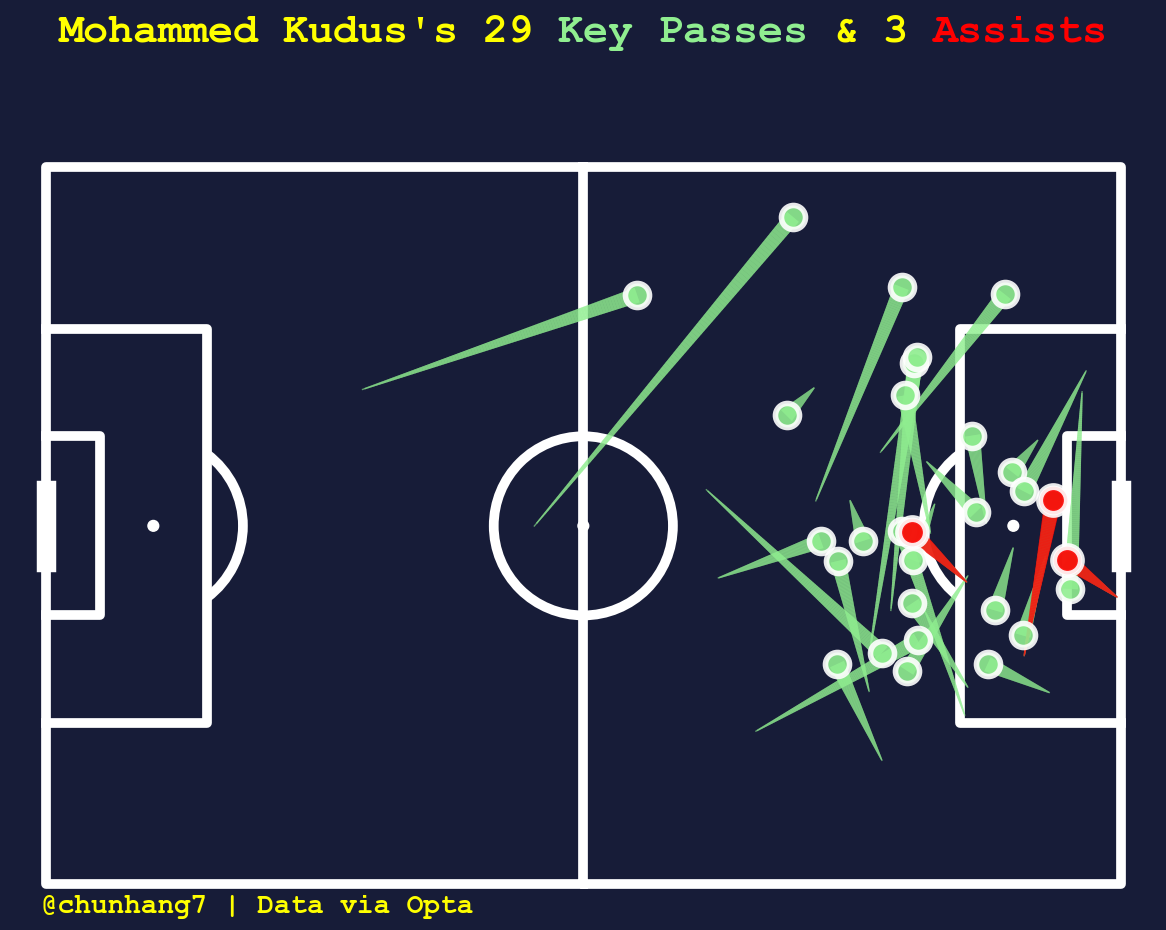

In [6]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=7, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(14,9), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#inverse y-axis
plt.gca().invert_yaxis()

#Key Passes
pitch.lines(KPdf.prev_x ,KPdf.prev_y ,KPdf.prev_endX, KPdf.prev_endY,
            ax=ax, comet = True, color= 'lightgreen', lw=11, alpha = 0.6)

pitch.scatter(KPdf.prev_endX, KPdf.prev_endY, edgecolors= 'w', c='lightgreen',
              s = 300, zorder=4, ax=ax, marker = 'o', alpha = 0.9, linewidths=4)

#Assist
if Assist.empty == False:
    pitch.lines(Assist.prev_x ,Assist.prev_y ,Assist.prev_endX, Assist.prev_endY,
                ax=ax, comet = True, color= 'red', lw=12, alpha = 0.6)
    
    pitch.scatter(Assist.prev_endX, Assist.prev_endY, edgecolors= 'w', c='red',
                  s = 400, zorder=4, ax=ax, marker = 'o', alpha = 0.9,linewidths=5)
#highlights
highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "red","fontweight": 'bold'}]

fig_text(s = player + "'s " + str(numKP) + " <Key Passes> & " + str(numassist) + " <Assists>\n" ,
        x = 0.5, y = 1.0, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', va='center',ha='center',fontsize=30);

ax.text(-0.5, -2.5, '@chunhang7 | Data via Opta', va='center', ha='left', fontsize=20,
        fontfamily='Courier New', color='yellow',fontweight = "bold");

# Vertical Pitch

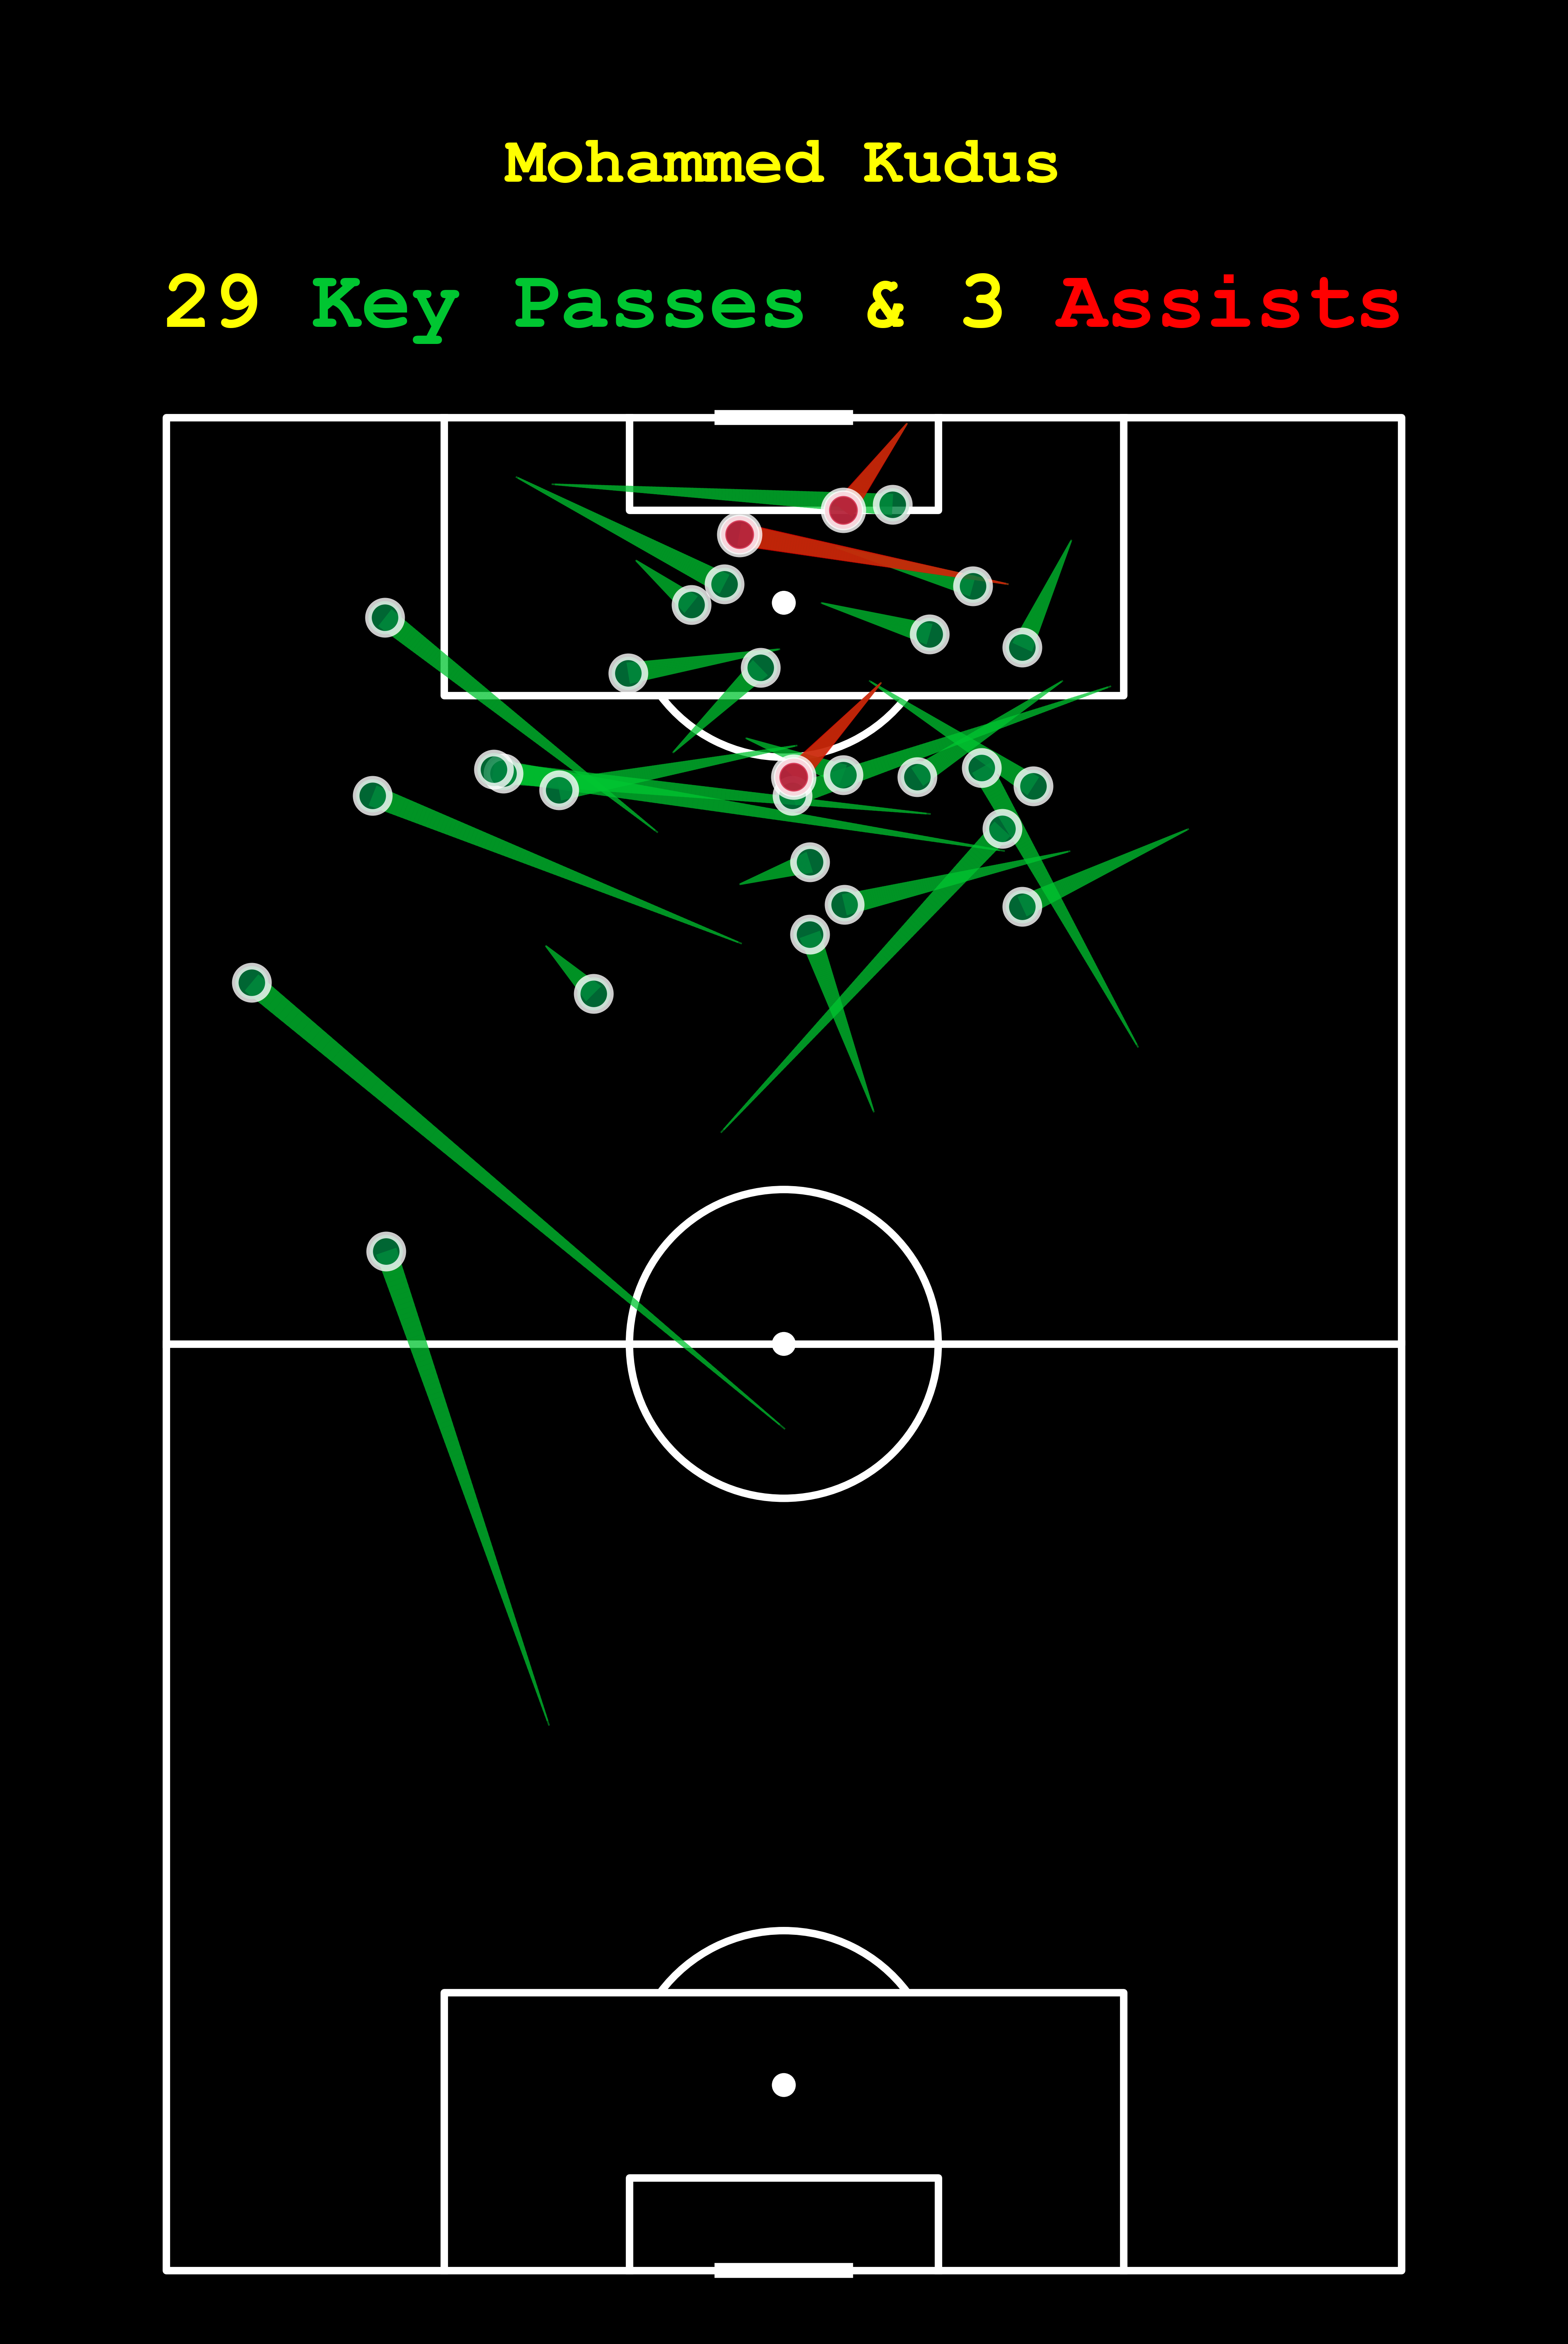

In [7]:
#Set up pitch
mpl.rcParams['figure.dpi'] = 300
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Key Passes
pitch.lines(KPdf.prev_x ,KPdf.prev_y ,KPdf.prev_endX, KPdf.prev_endY,
            ax=ax, comet = True, color= '#00c631', lw=13, alpha = 0.5)

pitch.scatter(KPdf.prev_endX, KPdf.prev_endY, edgecolors= 'w', c='#008140',
              s = 400, zorder=4, ax=ax, marker = 'o', alpha = 0.8, linewidths=4)

#Assist
if Assist.empty == False:
    pitch.lines(Assist.prev_x ,Assist.prev_y ,Assist.prev_endX, Assist.prev_endY,
                ax=ax, comet = True, color= 'red', lw=14, alpha = 0.5)
    
    pitch.scatter(Assist.prev_endX, Assist.prev_endY, edgecolors= 'w', c='crimson',
                  s = 500, zorder=4, ax=ax, marker = 'o', alpha = 0.8,linewidths=5)
    
#Title & Annotations
fig.suptitle("\n\n" + player + "\n\n", fontsize=40, color='yellow',
            fontfamily = "Courier New", fontweight = "bold", y=0.98)

#highlights
highlight_textprops =\
    [{"color": "#00c631","fontweight": 'bold'},
     {"color": "red","fontweight": 'bold'}]

fig_text(s = str(numKP) + " <Key Passes> & " + str(numassist) + " <Assists>" ,
        x = 0.5, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=50);
"""
fig_text(s = "25 <Key Passes> | 1 <Assists>" ,
        x = 0.5, y = 0.875, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=50);"""

ax.text(90, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-2, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

# Attacking Half of the Pitch

In [9]:
#Set up pitch
mpl.rcParams['figure.dpi'] = 500
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = True,
                  line_zorder=-3, linewidth=8, spot_scale=0.003)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()


#Arrow

pitch.scatter(KPdf.prev_x, KPdf.prev_y, edgecolors= 'yellow', c='#008140',alpha=0.8,
              s = 500, zorder=4, ax=ax, marker = 'o', linewidth=4)

pitch.lines(KPdf.prev_x ,KPdf.prev_y ,KPdf.prev_endX, KPdf.prev_endY,
            ax=ax, color= '#00c631', lw=8, alpha = 0.7)

pitch.scatter(KPdf.prev_endX, KPdf.prev_endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 1200, zorder=4, ax=ax, linewidth=5)

if Assist.empty == False:
    pitch.scatter(Assist.prev_x, Assist.prev_y, edgecolors= 'yellow', c='crimson',alpha=0.,
              s = 500, zorder=4, ax=ax, marker = 'o', linewidth=4)

    pitch.lines(Assist.prev_x ,Assist.prev_y ,Assist.prev_endX, Assist.prev_endY,
            ax=ax, color= 'crimson', lw=8, alpha = 0.9)

    pitch.scatter(Assist.prev_endX, Assist.prev_endY, edgecolors= 'yellow', c='crimson',marker=arrowhead_marker,
              s = 1200, zorder=4, ax=ax, linewidth=5)

#Title & Annotations
fig.suptitle("\n\nMohammed Kudus | Eredivisie 22/23\n", fontsize=68, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.98)

#highlights
highlight_textprops =\
    [{"color": "#00c631","fontweight": 'bold'},
     {"color": "red","fontweight": 'bold'}]

fig_text(s = str(numKP) + " <Key Passes> (" + str(numassist) + " <Assists>)\n" ,
        x = 0.5, y = 0.81, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=60);

ax.text(-5, 70, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(89, 70, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(25, 62, '@chunhang7 | Data via Opta', va='center', ha='left', fontsize=25, color='w',
        fontweight = "bold",fontfamily = "Courier New", zorder=8)

plt.show()